<a href="https://colab.research.google.com/github/hyewonleess/MiraeAssetContest/blob/master/%EB%B3%B4%ED%97%98%EB%82%98%EB%9D%BC_%EC%BD%94%EB%94%A9%EA%B3%B5%EC%A3%BC_%EC%B5%9C%EC%A2%85%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**[미래에셋 머신러닝 경진대회 - 보험금 청구 건 분류]**

##보험나라 코딩공주(팀명)

##2020년 10월 4일 (제출날짜)


---



#1. 라이브러리 및 데이터 이해하기

> Library & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import lightgbm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import OrderedDict

from tqdm import tqdm_notebook
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# 한글 폰트 설정
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='NanumBarunGothic')

## 데이터 로드 및 변수명 변경

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# train, test 데이터 로드
train = pd.read_csv('/content/drive/My Drive/data/train.csv',header=0)
test = pd.read_csv('/content/drive/My Drive/data/test.csv',header=0)

In [4]:
# 영어 -> 한글로 변수명 변경
variable = ['ID','base_ym','dsas_ltwt_gcd','kcd_gcd','dsas_acd_rst_dcd','ar_rclss_cd','blrs_cd','mdct_inu_rclss_dcd','nur_hosp_yn','optt_nbtm_s','bilg_isamt_s','hspz_dys_s','hsp_avg_hspz_bilg_isamt_s','hsp_avg_optt_bilg_isamt_s',
            'hsp_avg_surop_bilg_isamt_s','hsp_avg_diag_bilg_isamt_s','dsas_avg_hspz_bilg_isamt_s','dsas_avg_optt_bilg_isamt_s','dsas_avg_surop_bilg_isamt_s','dsas_avg_diag_bilg_isamt_s','hspz_blcnt_s','surop_blcnt_s','optt_blcnt_s',
            'isrd_age_dcd','fds_cust_yn','smrtg_5y_passed_yn','mtad_cntr_yn','heltp_pf_ntyn','prm_nvcd','inamt_nvcd','ac_ctr_diff','ac_rst_diff','urlb_fc_yn','target']
variable_kor = ['접수일련번호','접수년월','질병경중등급코드','KCD등급코드','질병구분코드','발생지역구분코드','치료행위코드','의료기관구분코드','요양병원여부','통원횟수','청구보험금','입원일수','병원별평균입원청구보험금',
                '병원별평균통원청구보험금','병원별평균수술청구보험금','병원별평균진단청구보험금','질병별평균입원청구보험금','질병별평균통원청구보험금','질병별평균수술청구보험금','질병별평균진단청구보험금','입원청구건수',
                '수술청구건수','통원청구건수','고객나이구분코드','보험사기이력고객여부','부담보5년경과여부','중도부가계약여부','건강인우대계약여부','보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드',
                '청구일부활일간기간구분코드','부실판매자계약여부','실사상태코드']
variable_df = pd.DataFrame({'variable':variable,'variable_kor':variable_kor})
train = train[variable]
train_kor = train.copy()
train_kor.columns = variable_kor
test = test[variable[:-1]]
test_kor = test.copy()
test_kor.columns = variable_kor[:-1]

In [ ]:
# 데이터 미리보기
train_kor.head()

,접수일련번호,접수년월,질병경중등급코드,KCD등급코드,질병구분코드,발생지역구분코드,치료행위코드,의료기관구분코드,요양병원여부,통원횟수,청구보험금,입원일수,병원별평균입원청구보험금,병원별평균통원청구보험금,병원별평균수술청구보험금,병원별평균진단청구보험금,질병별평균입원청구보험금,질병별평균통원청구보험금,질병별평균수술청구보험금,질병별평균진단청구보험금,입원청구건수,수술청구건수,통원청구건수,고객나이구분코드,보험사기이력고객여부,부담보5년경과여부,중도부가계약여부,건강인우대계약여부,보험료구간코드,가입금액구간코드,청구일계약일간기간구분코드,청구일부활일간기간구분코드,부실판매자계약여부,실사상태코드
0,0,201901,1,3,1,1,12,2,0,0.8571,0.4240,0.3452,1.6021,0.1303,0.0000,0.0000,1.2612,1.2002,1.1701,0.9793,10.0000,0.0,2.0,3,0,0,0,0,1,4,6,0,0,1
1,1,201901,3,8,22,4,2,1,1,0.0000,0.8602,0.0000,0.0000,0.0000,0.5770,0.0000,0.0023,0.0000,0.1508,0.0000,0.0000,1.0,0.0,4,0,0,0,0,1,4,6,0,0,0
2,2,201901,3,8,22,1,2,1,1,0.0000,0.4301,0.0000,0.0000,0.0000,0.2885,0.0000,0.0023,0.0000,0.1508,0.0000,0.0000,1.0,0.0,4,1,0,0,0,1,6,6,0,0,1
3,3,201901,3,8,23,2,8,2,0,0.0000,0.2509,0.8056,0.5638,0.0197,0.0680,0.0587,0.1920,0.0000,0.0863,0.0000,1.4444,0.0,0.0,9,0,0,0,0,1,6,4,0,0,1
4,4,201901,3,8,23,9,8,2,0,0.0000,0.0323,0.4167,0.4464,0.0000,0.0000,0.0000,0.1920,0.0000,0.0863,0.0000,1.3333,0.0,0.0,0,0,0,0,0,2,2,5,0,0,1


## 데이터 이해

### Target (`실사상태코드`) 분포


> Train data 의 타겟 분포가 불균형합니다. **심사(1) > 자동지급(0) > 조사(2)**  순으로 분류된 건수가 많습니다.



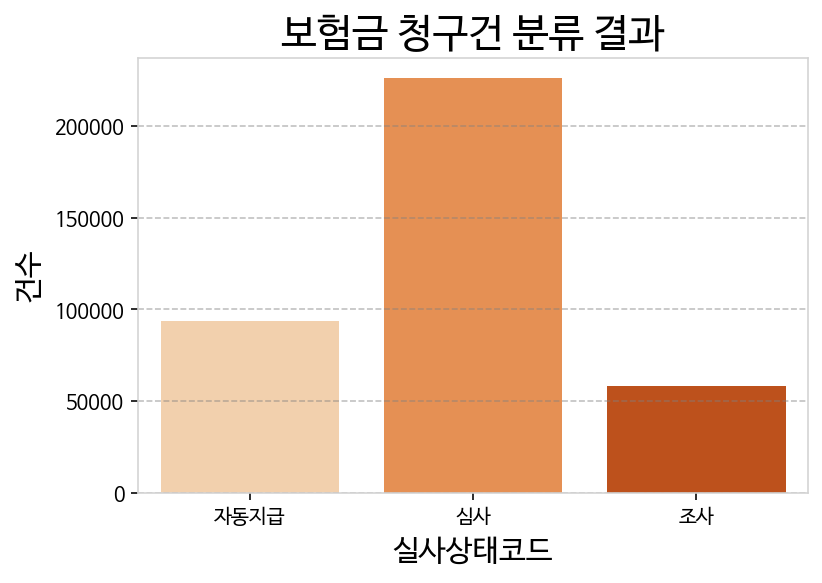

In [ ]:
target_count = train_kor['실사상태코드'].value_counts().reset_index().rename(columns = {'index':'실사상태코드','실사상태코드':'건수'})

def target_plot(data, x_var, y_var):
  plt.figure(figsize = (6,4))
  ax = plt.subplot(1,1,1)
  sns.barplot(data=data,x = x_var,y = y_var ,palette = 'Oranges', ax = ax)
  ax.set_title('보험금 청구건 분류 결과',fontsize=20); plt.xticks([0,1,2], ['자동지급','심사','조사'])
  ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
  ax.tick_params(axis='both', which='major', labelsize=10)
  plt.xlabel(x_var, fontsize=15); plt.ylabel(y_var, fontsize=15)
  plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
  plt.show()

target_plot(target_count, '실사상태코드', '건수')

### 변수 data type 별 탐색



#### 1) 정수형 변수

> 정수형 변수 중 Boolean type (0 or 1) 자료가 가장 많으며, 모든 정수형 변수는 Categorical 변수입니다.



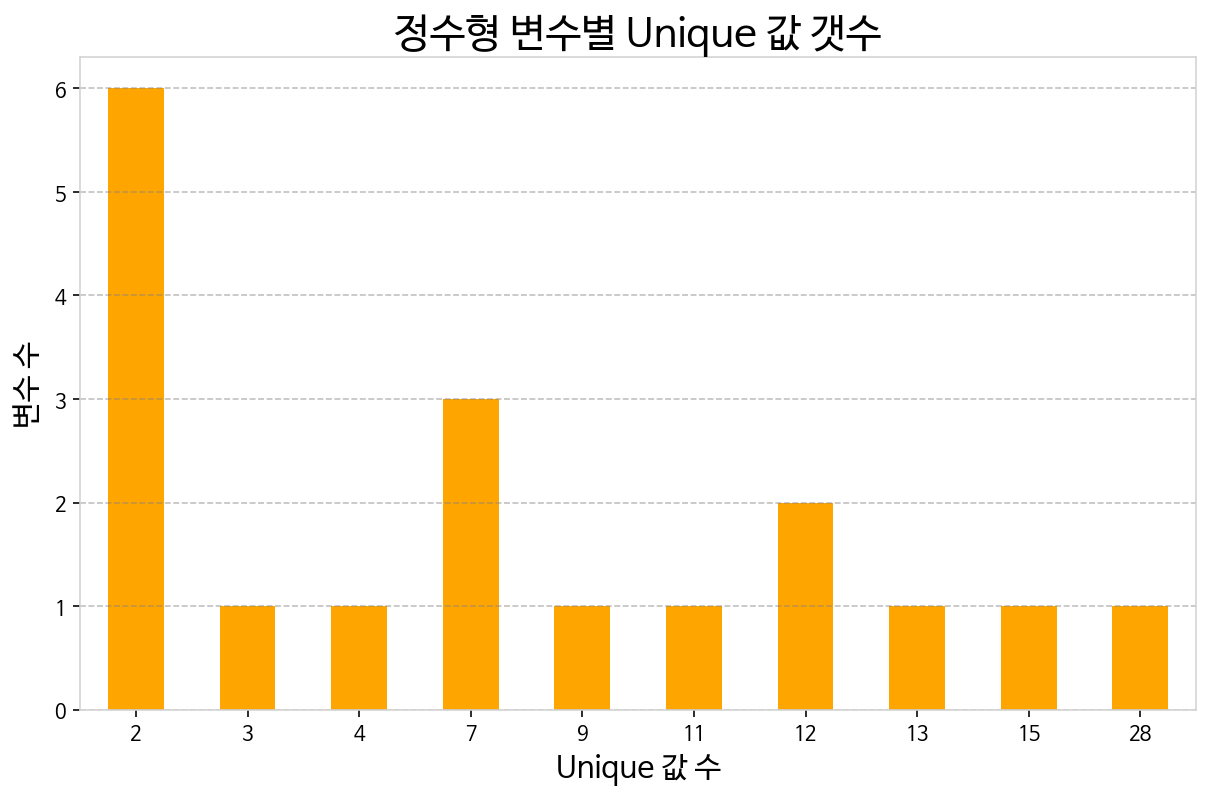

In [ ]:
int_vars = train_kor.drop(['접수일련번호','실사상태코드'], axis=1)

ax = int_vars.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='orange', figsize=(10,6))
ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
plt.xticks(rotation = 0)
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.title('정수형 변수별 Unique 값 갯수', fontsize=20); plt.xlabel('Unique 값 수', fontsize=15); plt.ylabel('변수 수', fontsize=15)
plt.show()

#### 2) 실수형 변수

> 실수형 변수를 대상으로 실사상태코드(Target) 별 커널밀도함수를 그린 결과, 각 실수형 변수의 값에 따라 보험금청구건분류 결과가 상이하게 나타난다는 것을 확인할 수 있습니다. <br>

따라서 실수형 변수들은 보험금청구건 분류결과를 예측할 때, 중요한 feature로 작용한다는 것을 예상할 수 있습니다. 


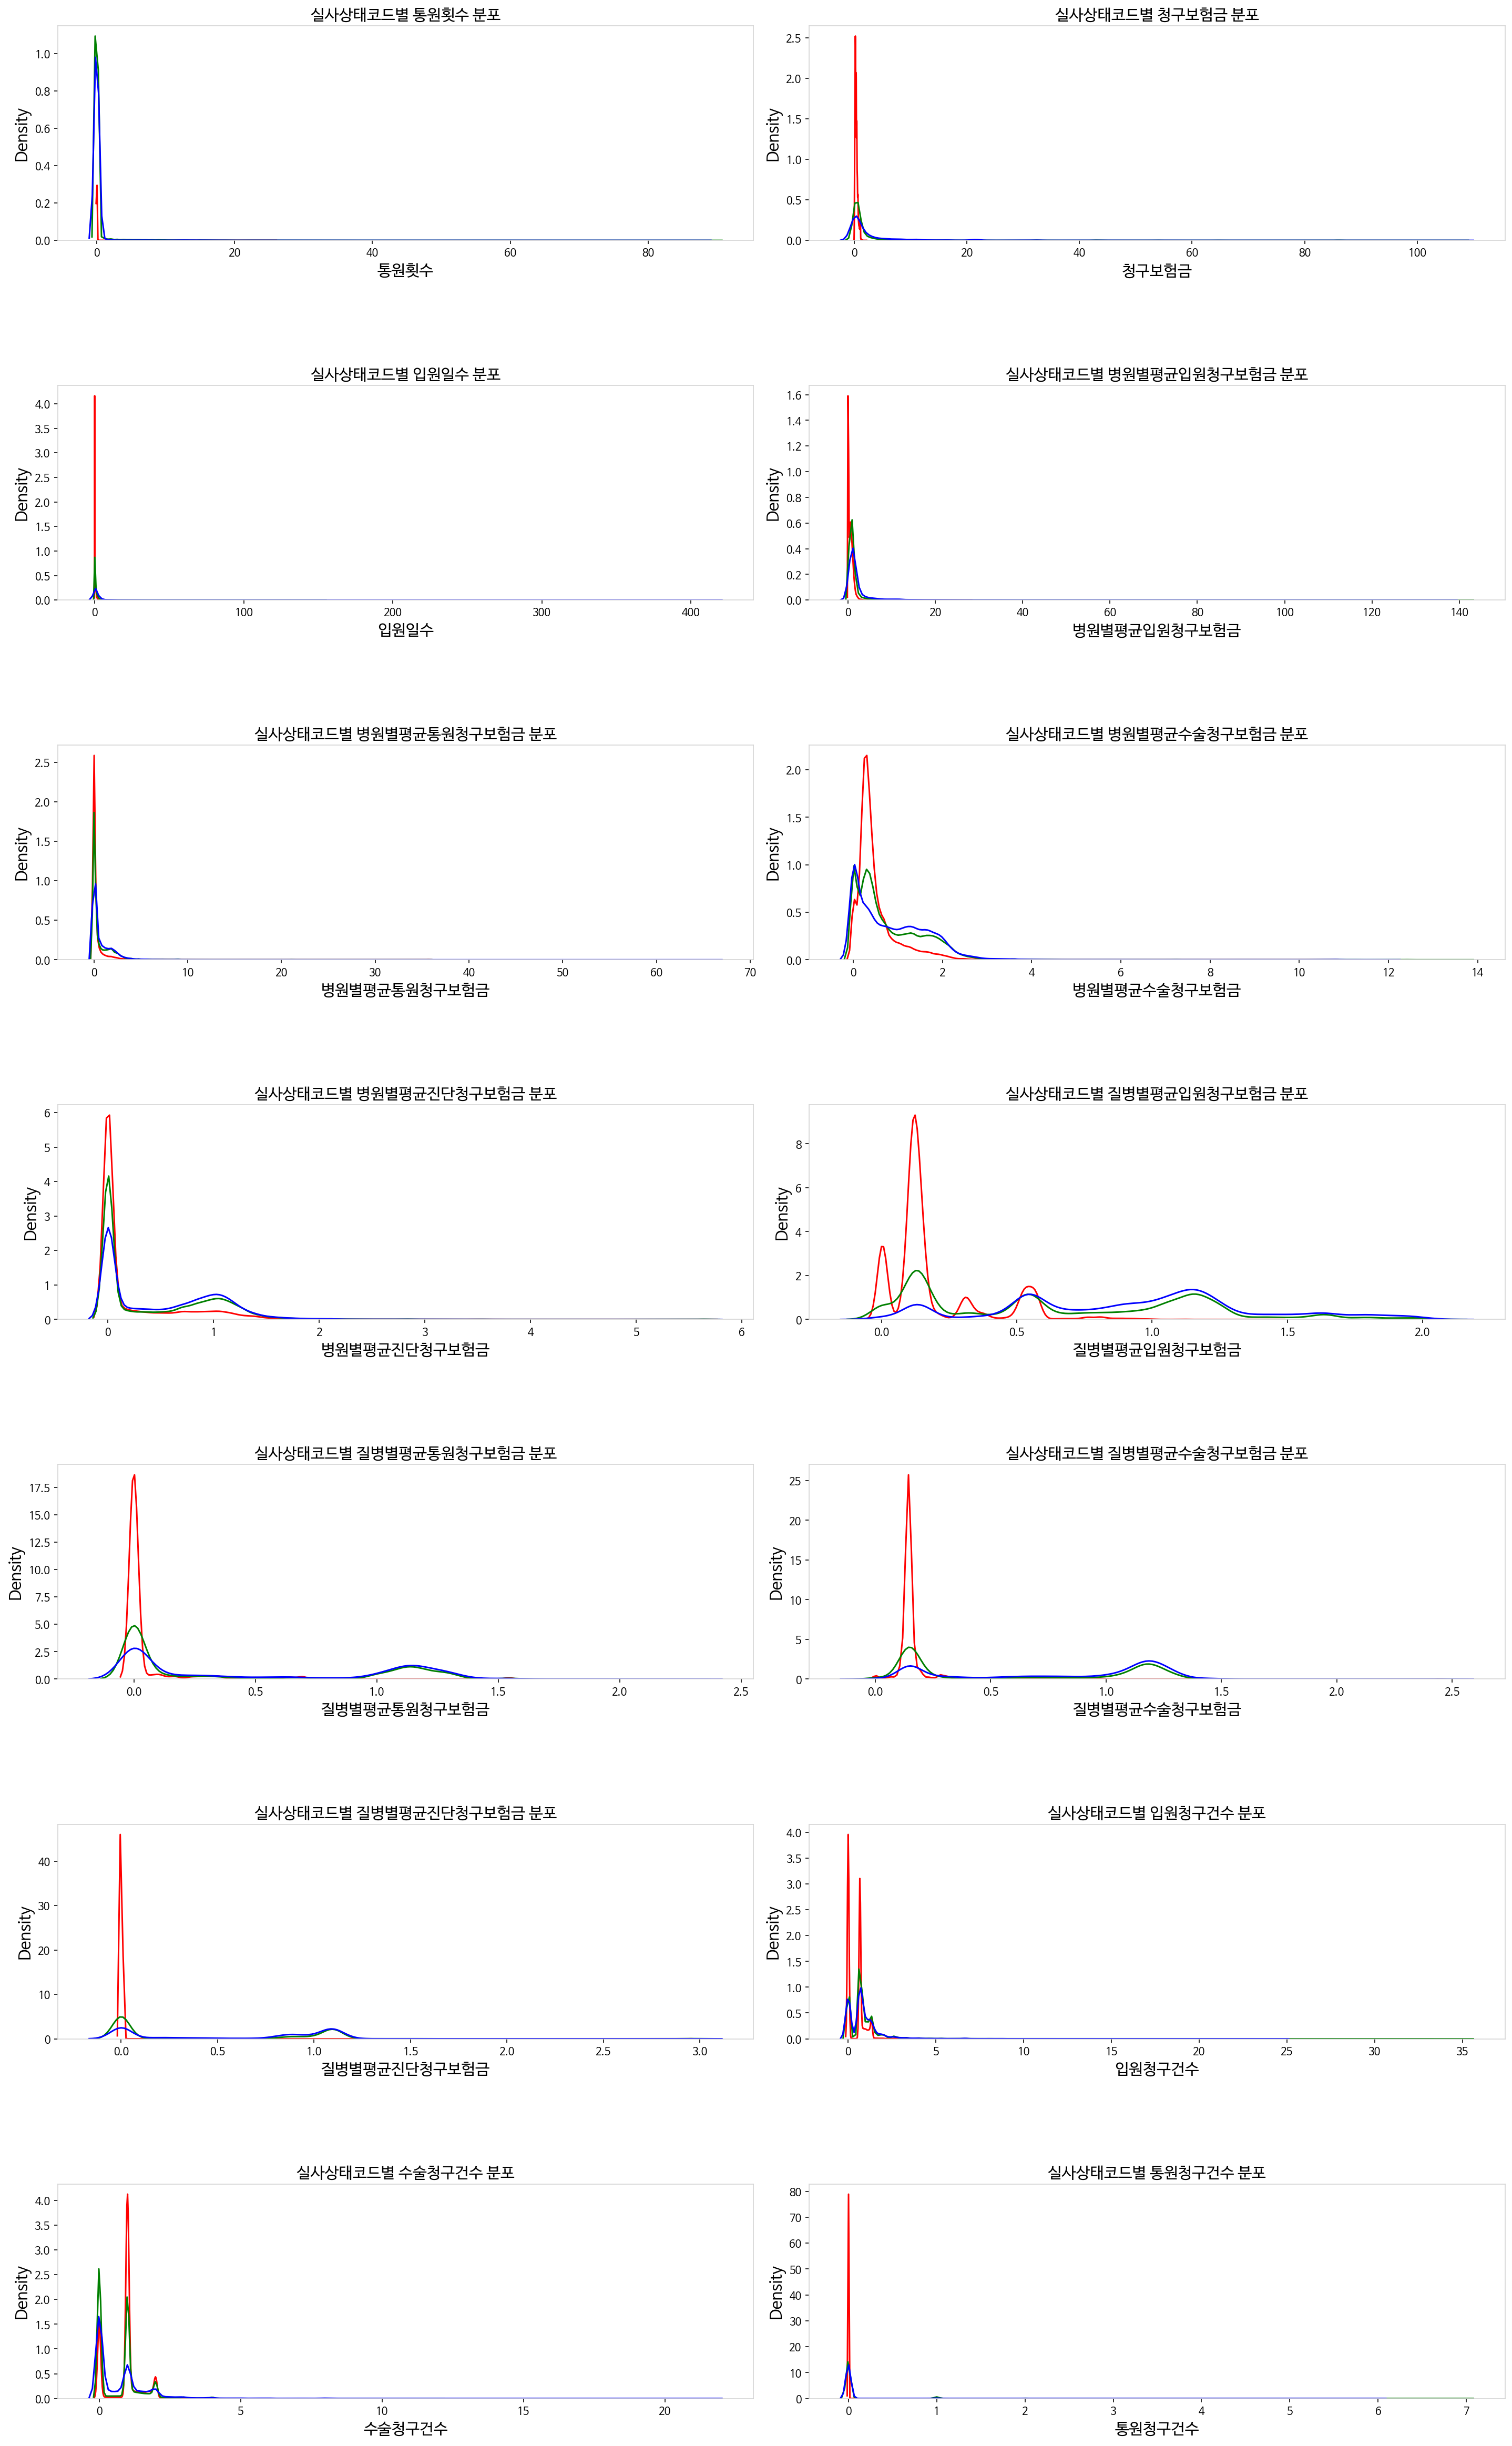

In [ ]:
plt.figure(figsize = (20,16))

colors = OrderedDict({0:'red',1:'green',2:'blue'})
target_map = OrderedDict({0:'자동지급',1:'심사',2:'조사'})

for i,col in enumerate(train_kor.select_dtypes('float')):
    ax = plt.subplot(7,2,i+1)
    for standard,color in colors.items():
        sns.kdeplot(train_kor.loc[train_kor['실사상태코드'] == standard,col].dropna(),
                   ax = ax, color = color, label = target_map[standard])
        ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
    plt.title(f'실사상태코드별 {col.capitalize()} 분포', fontsize = 15);
    plt.xlabel(f'{col}', fontsize=15); plt.ylabel('Density', fontsize = 15)
    plt.tight_layout()
plt.subplots_adjust(top=2)

#2. EDA: 탐색적 자료 분석


> Exploratory Data Analysis / Visualization



###`접수년월`
>- 접수년월에서 실사상태코드(target)별 분포를 보면 계절성에 따라 ’심사’와 ‘조사’의 유의미한 패턴을 볼 수 있습니다.
- 11월, 1월이 속한 겨울과 7월이 있는 여름에 ‘조사’의 비율이 낮아지는 것을 확인할 수 있습니다.
- 이에 따라 ‘심사’는 반대로 비율이 높아지는 경향이 있습니다.
- 이와 별개로 접수년월에 따른 ‘자동지급’의 특정한 패턴은 없는 것을 볼 수 있습니다. <br>

따라서 주어진 데이터가 **계절성**을 띈다고 판단하여, 2019년 12월의 보험금청구건분류를 예측하기 위해 계절성 및 주기성을 나타내는 변수를 추가했습니다.

In [ ]:
train_2 = train_kor.copy()
test_2 = test_kor.copy()

# 월(month) 칼럼 생성
train_2['접수월'] = pd.to_datetime(train_2['접수년월'].astype(str),format = '%Y%m').dt.month
test_2['접수월'] = pd.to_datetime(test_2['접수년월'].astype(str),format = '%Y%m').dt.month

In [ ]:
# Target 비율 plot 함수 

# 월별 분포에 적용
def bar_stack_target_month(df,x_var):
    group = df.groupby([x_var,'실사상태코드'])['접수일련번호'].count()
    group = group/group.groupby(level=0).sum()
    group = group.reset_index().rename(columns={'접수일련번호':'비율'})
    group1 = group[group['실사상태코드'] == 1]
    group2 = group[group['실사상태코드'] == 2]
    group1['접수월'] = group1['접수월']-1
    group2['접수월'] = group2['접수월']-0.8
    
    ax = plt.subplot(1,1,1)
    colors = ['lightgreen','papayawhip','lightsalmon']
    sns.barplot(data = group,x = x_var,y = '비율',hue = '실사상태코드',palette = colors, ax = ax)
    sns.lineplot(data = group1,x = x_var,y = '비율',marker='^', ax = ax, color = 'orange', linewidth = 4, label='심사')
    sns.lineplot(data = group2,x = x_var,y = '비율',marker='o', ax = ax, color = 'red', linewidth = 4, label='조사')
    plt.text(0,0.65,'심사(1) 비율 변화', fontsize=13)
    plt.text(0,0.15,'조사(2) 비율 변화', fontsize=13)
    ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); 
    ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
    
    plt.title(f'{x_var}별 심사(1) 및 조사(2) 비율',fontsize = 20)
    plt.xlabel('접수월', fontsize = 15); plt.ylabel('비율(%)', fontsize= 15)
    plt.xticks(range(0,12), [str(i)+'월' for i in range(1,13)])
    plt.legend(loc = 'best')
    plt.grid(True, axis = 'y', color = 'gray', alpha = 0.5, linestyle='--')
    plt.show()

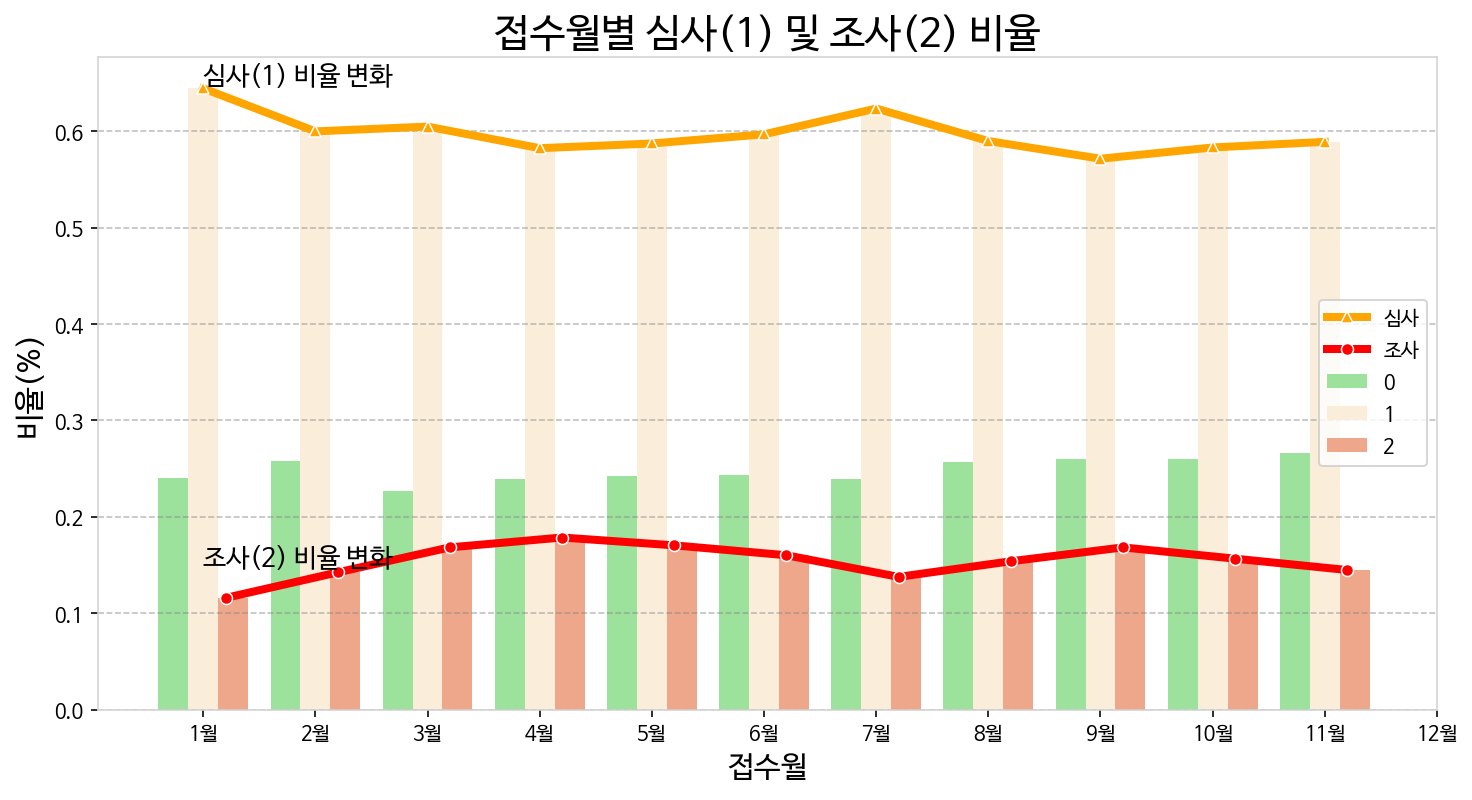

In [ ]:
plt.figure(figsize=(12,6))
bar_stack_target_month(train_2,'접수월')

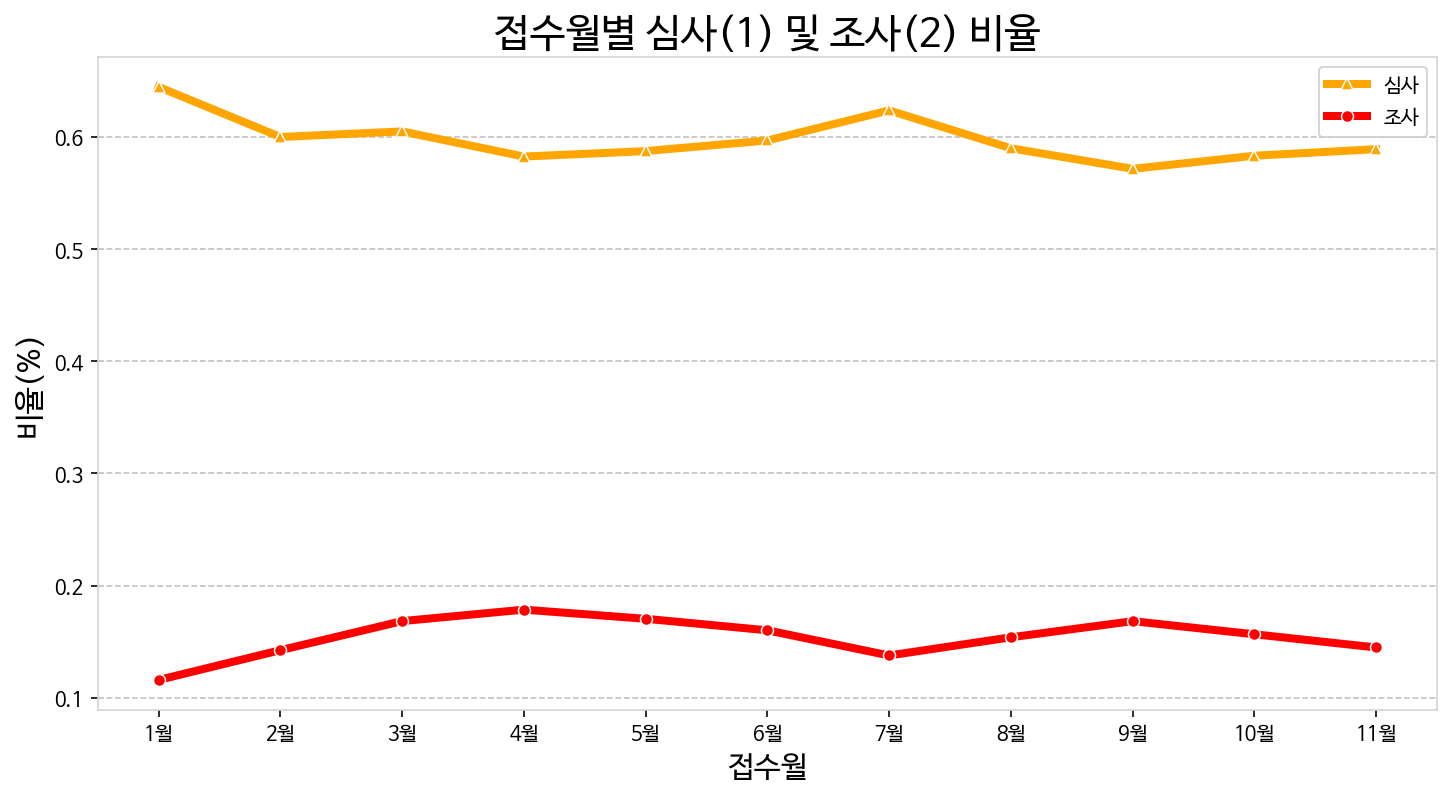

In [ ]:
# Target 비율 plot 함수 - line plot

# 월별 분포에 적용
def bar_stack_target_month_line(df,x_var):
    group = df.groupby([x_var,'실사상태코드'])['접수일련번호'].count()
    group = group/group.groupby(level=0).sum()
    group = group.reset_index().rename(columns={'접수일련번호':'비율'})
    group1 = group[group['실사상태코드'] == 1]
    group2 = group[group['실사상태코드'] == 2]
    group1['접수월'] = group1['접수월']
    group2['접수월'] = group2['접수월']
    
    ax = plt.subplot(1,1,1)
    #colors = ['lightgreen','papayawhip','lightsalmon']
    #sns.barplot(data = group,x = x_var,y = '비율',hue = '실사상태코드',palette = colors, ax = ax)
    sns.lineplot(data = group1,x = x_var,y = '비율',marker='^', ax = ax, color = 'orange', linewidth = 4, label='심사')
    sns.lineplot(data = group2,x = x_var,y = '비율',marker='o', ax = ax, color = 'red', linewidth = 4, label='조사')
    #plt.text(0,0.65,'심사(1) 비율 변화', fontsize=13)
    #plt.text(0,0.15,'조사(2) 비율 변화', fontsize=13)
    ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); 
    ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
    
    plt.title(f'{x_var}별 심사(1) 및 조사(2) 비율',fontsize = 20)
    plt.xlabel('접수월', fontsize = 15); plt.ylabel('비율(%)', fontsize= 15)
    plt.xticks(range(1,12), [str(i)+'월' for i in range(1,12)])
    plt.legend(loc = 'best')
    plt.grid(True, axis = 'y', color = 'gray', alpha = 0.5, linestyle='--')
    plt.show()

plt.figure(figsize=(12,6))
bar_stack_target_month_line(train_2,'접수월')

In [ ]:
# Target 비율 plot 함수 정의
def bar_stack_target_ver_1(df,x_var):
    group = df.groupby([x_var,'실사상태코드'])['접수일련번호'].count()
    group = group/group.groupby(level=0).sum()
    group = group.reset_index().rename(columns={'접수일련번호':'비율'})

    ax = plt.subplot(1,1,1)
    colors = ['lightgreen','papayawhip','lightsalmon']
    sns.barplot(data = group,x = x_var, y = '비율', hue = '실사상태코드', palette = colors, ax=ax)
    ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); 
    ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
    
    plt.title(f'{x_var}별 실사상태코드 분포', fontsize = 20); 
    plt.xlabel(f'{x_var}', fontsize = 15); plt.ylabel('비율(%)', fontsize = 15)
    plt.legend(loc = 'upper left')
    plt.grid(True, axis = 'y', color = 'gray', alpha = 0.5, linestyle = '--')
    plt.show()

def bar_stack_target_ver_2(df,x_var):
    group = df.groupby([x_var,'실사상태코드'])['접수일련번호'].count()
    group = group/group.groupby(level=0).sum()
    group = group.reset_index().rename(columns={'접수일련번호':'비율'})
    group2 = group[group['실사상태코드'] == 2]

    ax = plt.subplot(1,1,1)
    colors = ['whitesmoke','lightgrey','darkblue']
    sns.barplot(data = group,x = x_var,y = '비율',hue = '실사상태코드', palette = colors, ax=ax)
    sns.lineplot(np.arange(0.3, len(group2)+0.3, 1), group2['비율'], color = 'red', linewidth = 2, marker = 'o')
    ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); 
    ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
    
    plt.title(f'{x_var}별 실사상태코드 분포', fontsize = 20); 
    plt.xlabel(f'{x_var}', fontsize = 15); plt.ylabel('비율(%)', fontsize = 15)
    plt.legend(loc = 'upper left')
    plt.grid(True, axis = 'y', color = 'gray', alpha = 0.5, linestyle = '--')
    plt.show()

**변수 특성별로 나누기**

In [ ]:
id_=['접수일련번호','접수년월','실사상태코드'] 

# 고객정보
customer_order='고객나이구분코드' # 체크
customer_bool='보험사기이력고객여부' 
# 상품정보
products_bool=['부담보5년경과여부','중도부가계약여부','건강인우대계약여부']
products_order=['보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드','청구일부활일간기간구분코드']
# 판매자정보
seller='부실판매자계약여부'
# 질병정보
disease_bool='요양병원여부'
disease_order=['질병경중등급코드','KCD등급코드','질병구분코드','발생지역구분코드','치료행위코드','의료기관구분코드']
disease_conti=[x for x in train.columns if (x.endswith('보험금') or x.endswith('수'))]

### `고객나이구분코드`

>- 고객나이구분코드에서 나이가 많아질 수록 ‘자동지급’의 비율은 낮아지고 ‘조사’의 비율은 높습니다.
-명시되어 있지 않은 7과 9를 보면, 7은 ‘조사’의 비율이 극도로 높기 때문에 Unknown 데이터라고 추정됩니다. 9는 앞서 1과 2의 분포와 비슷하므로 10대~20대로 추정됩니다.

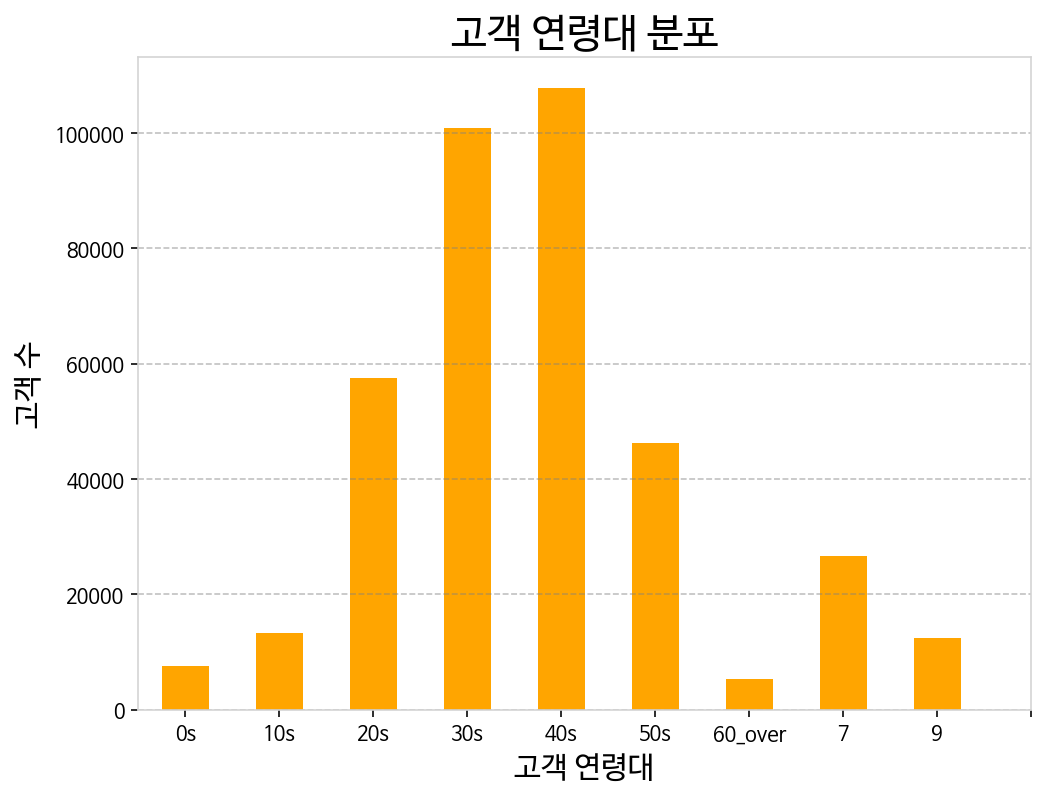

In [ ]:
ax = train_kor[customer_order].value_counts().sort_index().plot.bar(color='orange',figsize=(8,6))
plt.title('고객 연령대 분포',fontsize=20);plt.xlabel('고객 연령대',fontsize=15);plt.ylabel('고객 수',fontsize=15); plt.xticks(range(0,10),['0s','10s','20s','30s','40s','50s','60_over','7','9']);
plt.xticks(rotation = 0)
ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.show()

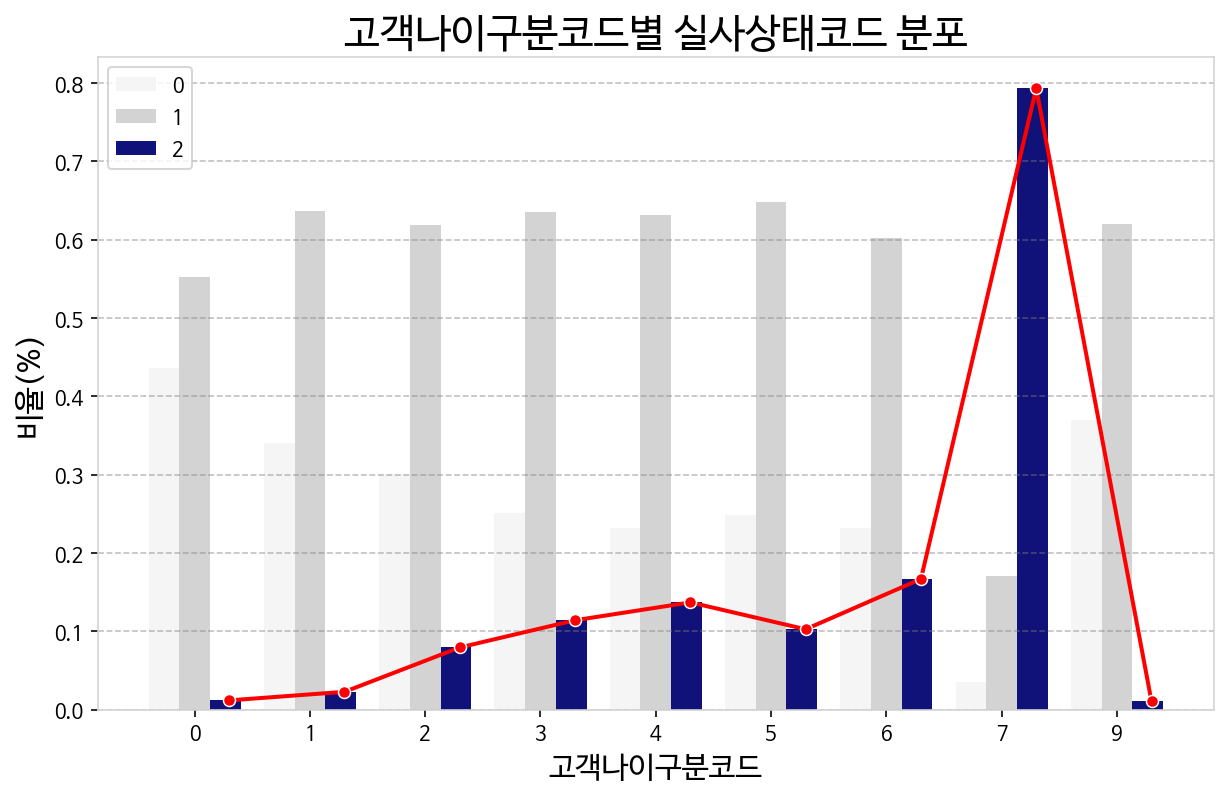

In [ ]:
plt.figure(figsize=(10,6))
bar_stack_target_ver_2(train_kor,'고객나이구분코드')

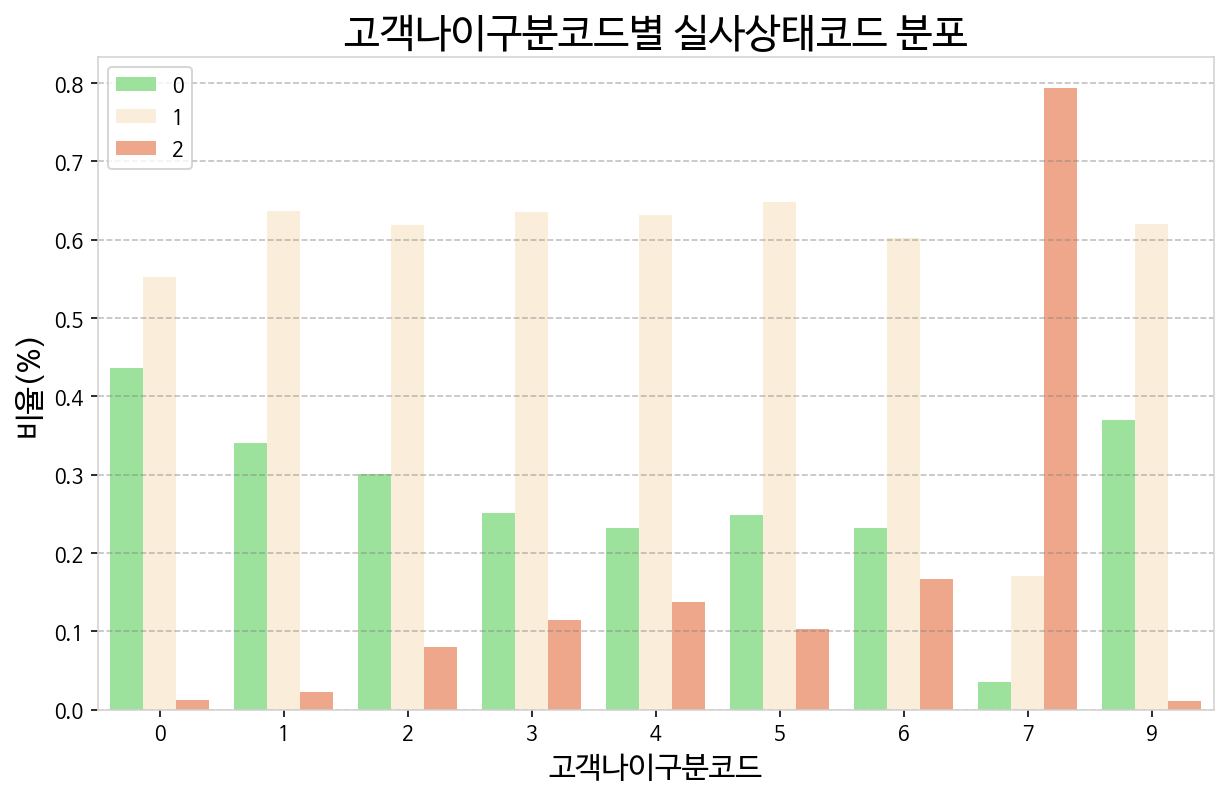

In [ ]:
plt.figure(figsize=(10,6))
bar_stack_target_ver_1(train_kor,'고객나이구분코드')

### `보험사기이력고객여부` & `부실판매자계약여부`

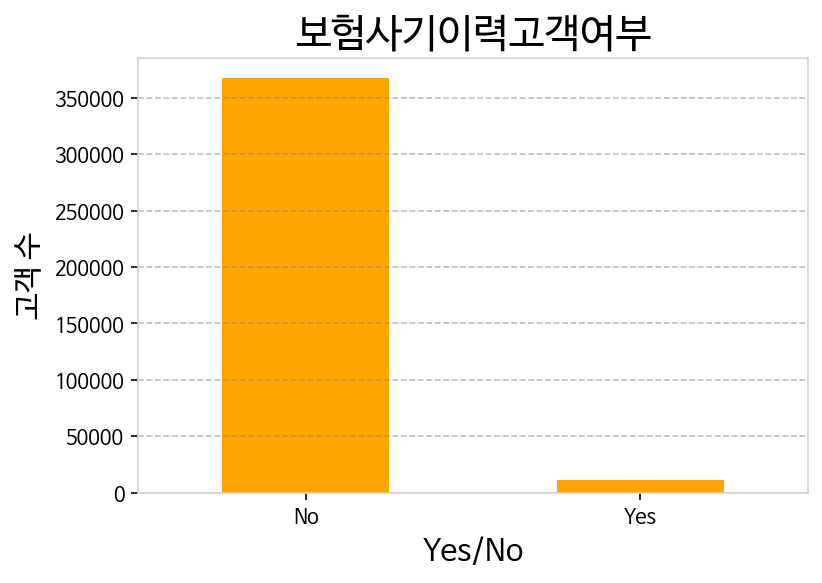

In [ ]:
ax = train_kor[customer_bool].value_counts().sort_index().plot.bar(color='orange',figsize=(6,4))
plt.title('보험사기이력고객여부',fontsize=20);plt.xlabel('Yes/No',fontsize=15);plt.ylabel('고객 수',fontsize=15); plt.xticks([0,1],['No','Yes']);
plt.xticks(rotation = 0)
ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.show()

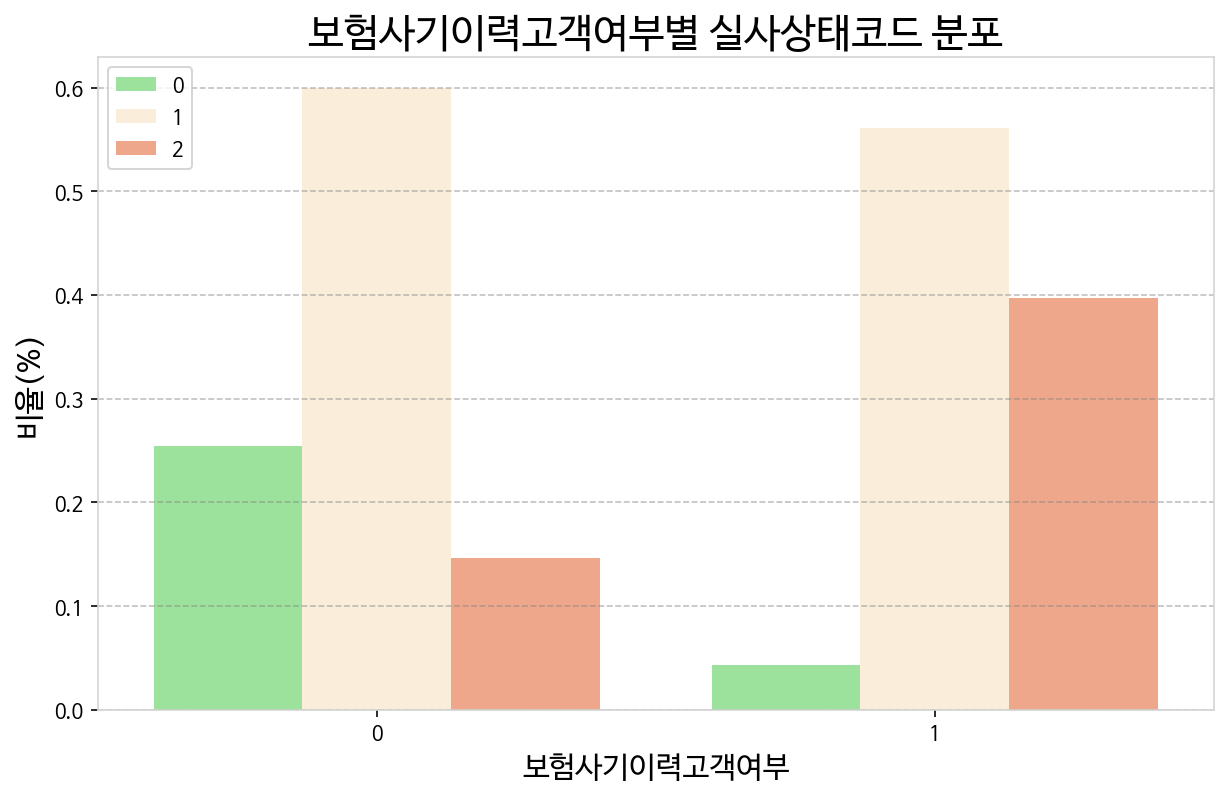

In [ ]:
plt.figure(figsize=(10,6))
bar_stack_target_ver_1(train_kor,'보험사기이력고객여부')

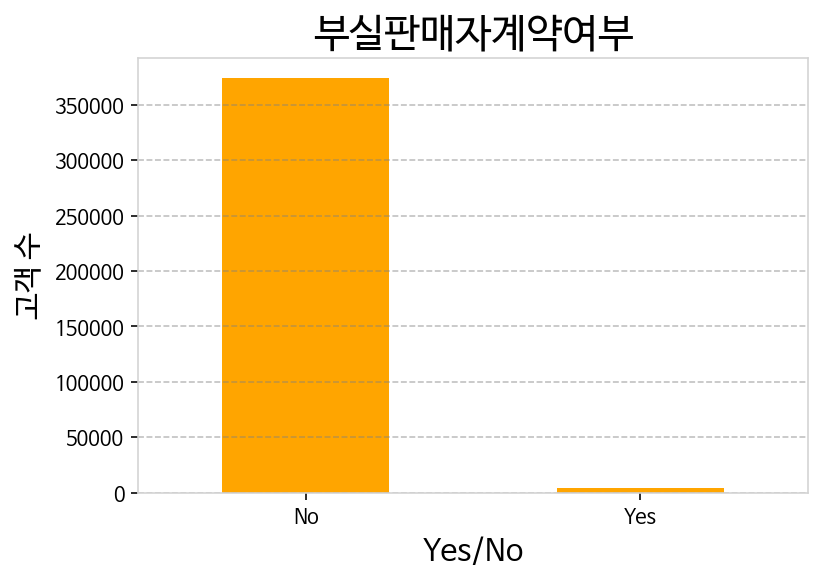

In [ ]:
ax = train_kor[seller].value_counts().sort_index().plot.bar(color='orange',figsize=(6,4))
plt.title('부실판매자계약여부',fontsize=20);plt.xlabel('Yes/No',fontsize=15);plt.ylabel('고객 수',fontsize=15); plt.xticks([0,1],['No','Yes']);
plt.xticks(rotation = 0)
ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.show()

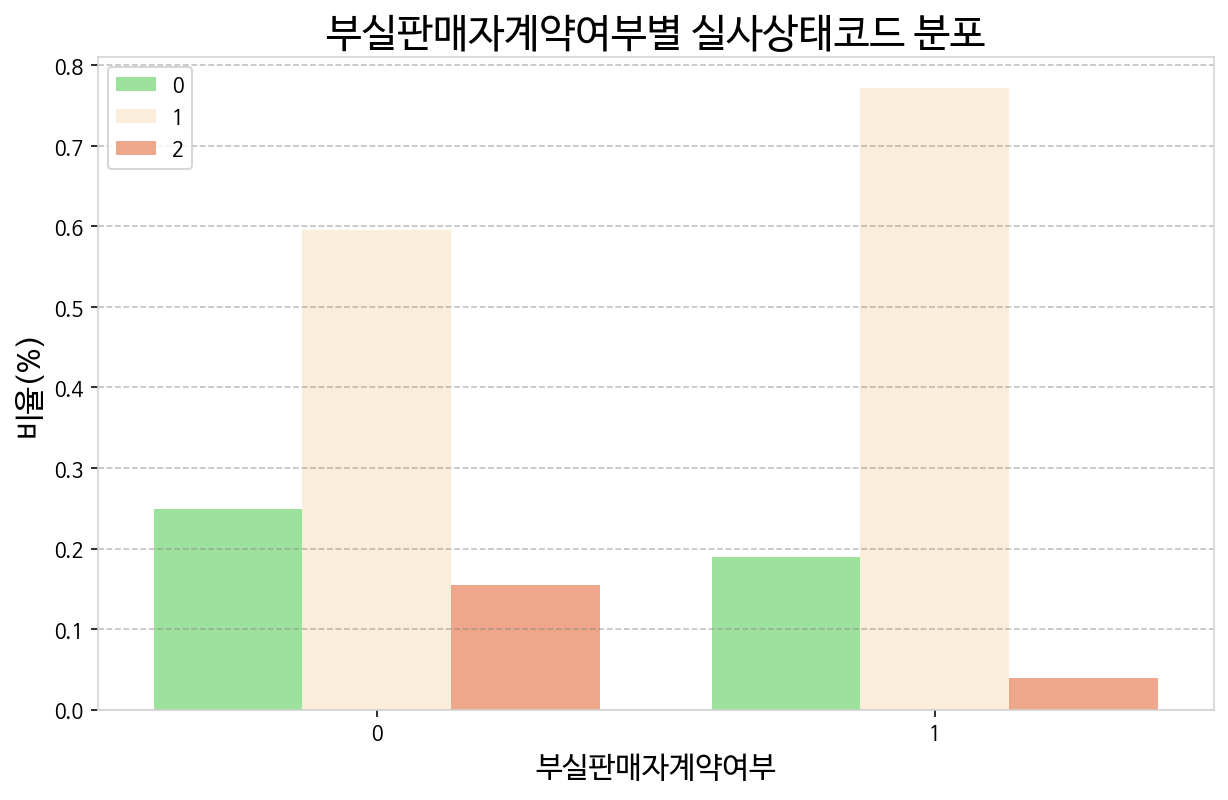

In [ ]:
plt.figure(figsize=(10,6))
bar_stack_target_ver_1(train_kor,'부실판매자계약여부')

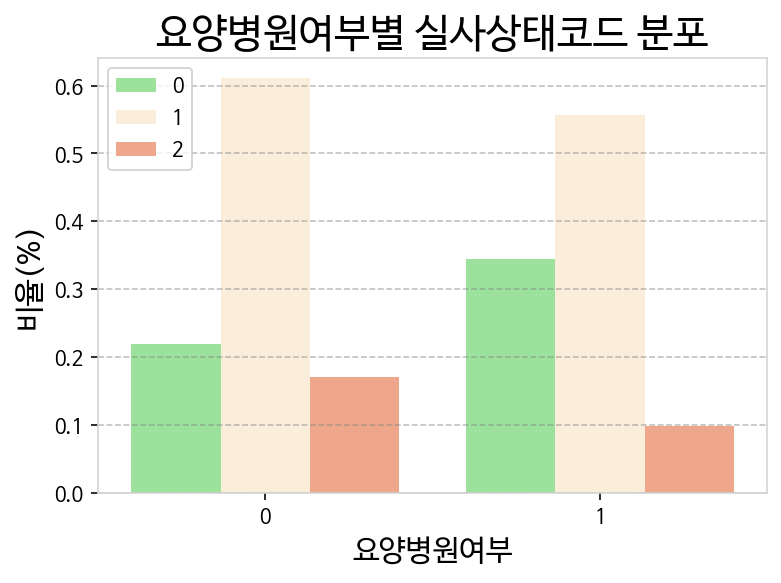

In [ ]:
plt.figure(figsize=(6,4))
bar_stack_target_ver_1(train_kor,'요양병원여부')

###`보험료구간코드`
>- 보험료구간코드별 고객 수 분포를 보면, 대부분 1(0~10만원 미만)에 다수가 있습니다. 
- 그 다음으로는 2(10만원~20만원)과 99(Unknown)에 해당하는 고객 수가 많았습니다.

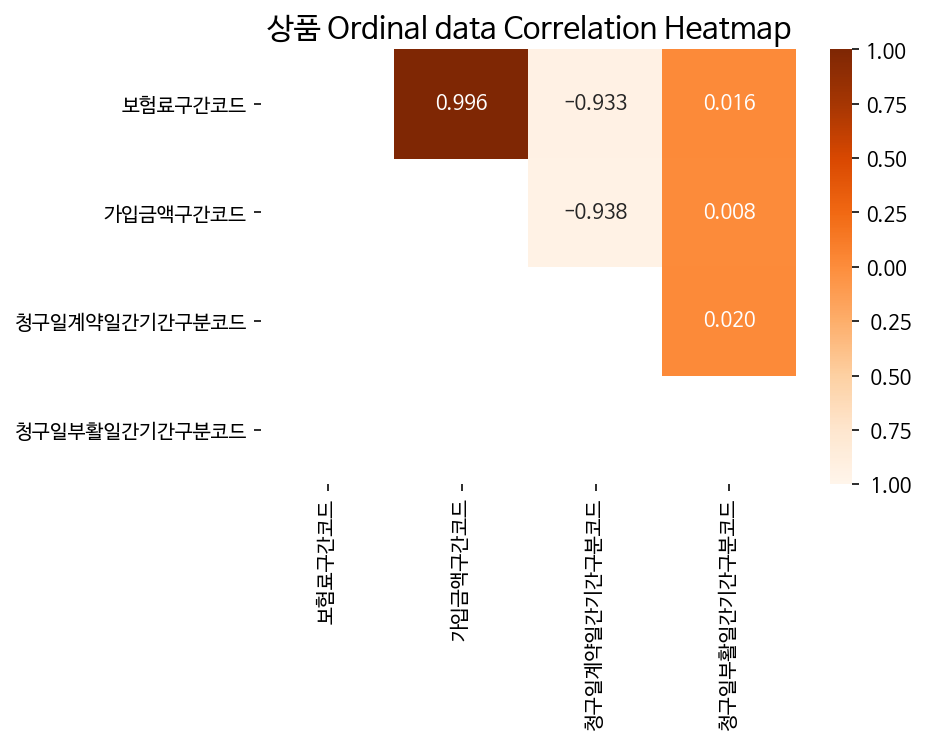

In [ ]:
corr_mat=train_kor[products_order].corr()
mask=np.zeros_like(corr_mat,dtype=np.bool)
mask[np.tril_indices_from(mask)]=True

sns.heatmap(corr_mat,annot=True,cmap='Oranges',mask=mask, vmax=1,vmin=-1,fmt='.3f')
plt.title('상품 Ordinal data Correlation Heatmap',fontsize=15)
plt.show()

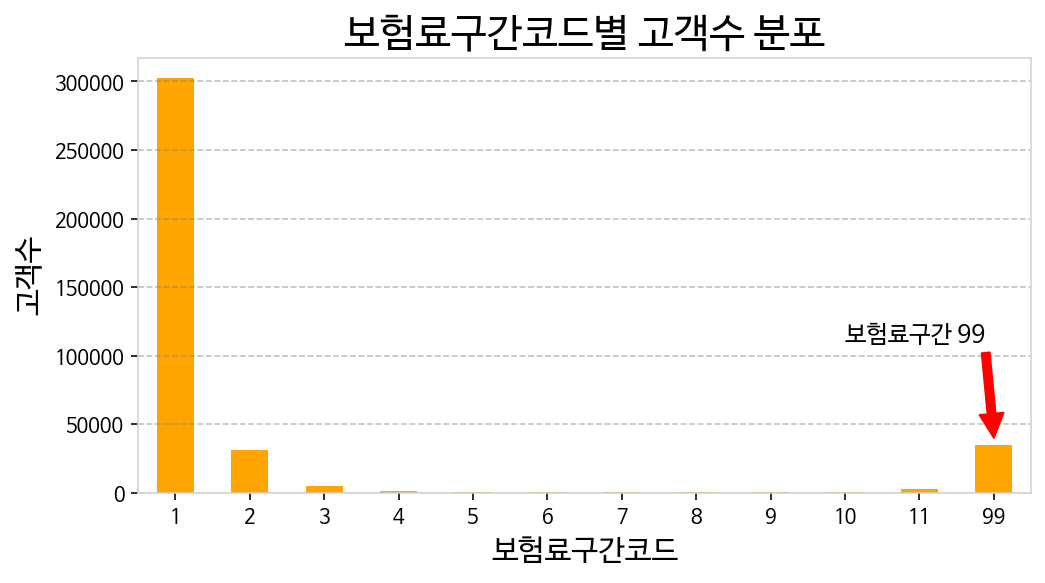

In [ ]:
ax = train_kor['보험료구간코드'].value_counts().sort_index().plot.bar(color='orange',figsize = (8,4))
ax.annotate('보험료구간 99', xy=(11,40000), xytext=(9,110000), arrowprops={'color':'red'}, fontsize = 12)
plt.title('보험료구간코드별 고객수 분포',fontsize=20)
plt.xticks(rotation = 0); plt.xlabel('보험료구간코드', fontsize = 15); plt.ylabel('고객수', fontsize = 15)
ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); 
ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
plt.grid(True, axis = 'y', color = 'gray', alpha = 0.5, linestyle = '--')
plt.show()

>- 보험료구간코드에서 실사상태코드별 분포를 보면, 높은 보험료를 낼 수록 ‘조사’의 비율이 높았지만 11(100만원 이상)에서는 다른 분포를 보였습니다. 
- 99(Unknwon)에서 ’조사’의 비율이 극도로 높습니다.
- `보험료구간코드` 99에 해당하는 데이터는 모두 `가입금액구간코드`가 99 입니다.

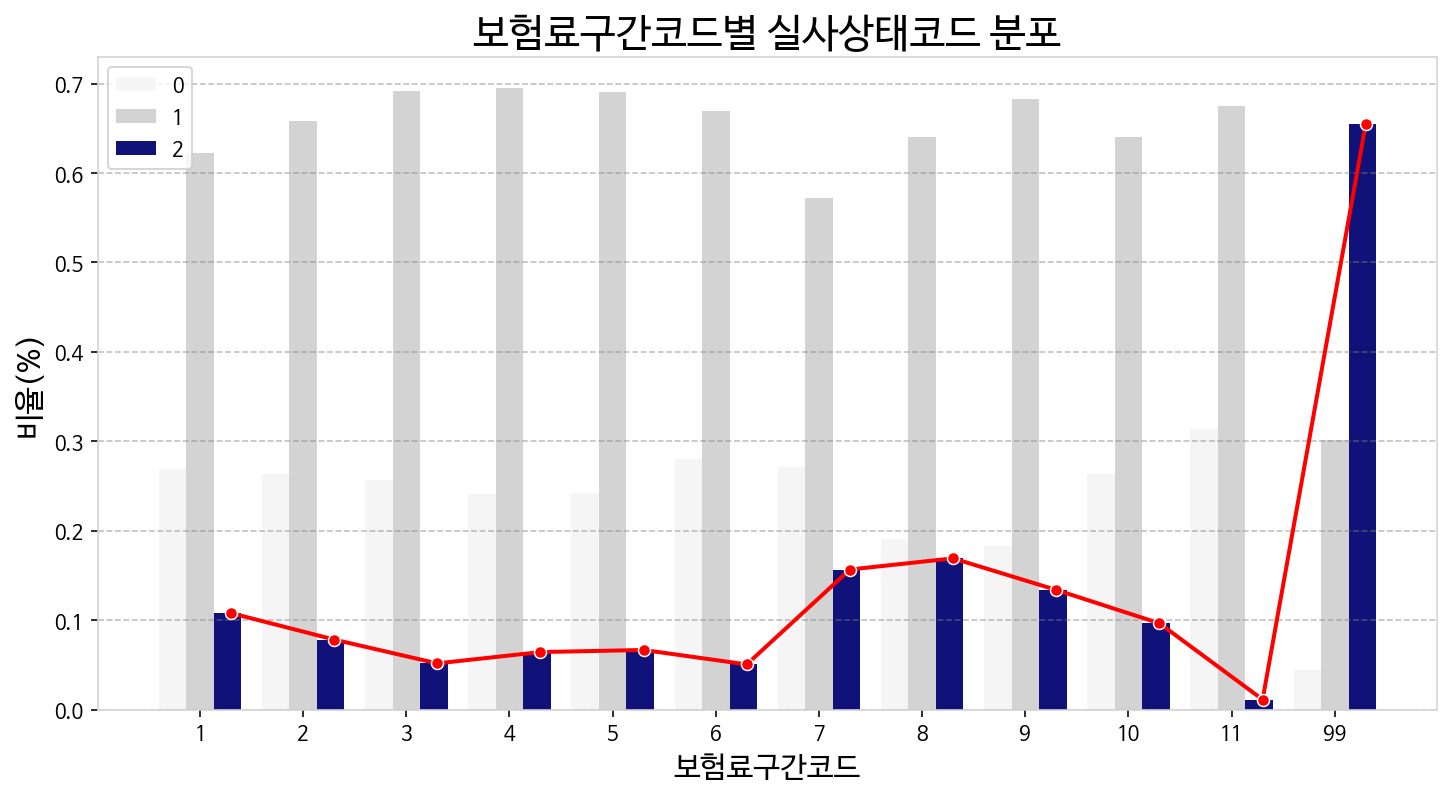

In [ ]:
plt.figure(figsize = (12,6))
bar_stack_target_ver_2(train_kor,'보험료구간코드')

In [ ]:
# 보혐료구간코드 99 및 가입금액구간코드 99
train_kor.loc[(train_kor['보험료구간코드']==99) & (train_kor['가입금액구간코드']==99) ,['보험료구간코드','가입금액구간코드']].head()

,보험료구간코드,가입금액구간코드
7,99,99
50,99,99
96,99,99
105,99,99
108,99,99


**보험료구간코드 99와 고객나이구분코드 7의 연관성**
>- 고객나이구분코드에서 보험료구간코드의 99(Unknown) 데이터와 원본 데이터를 보면, 99(Unknown) 데이터와 고객나이구분코드의 7 데이터의 분포가 유사하므로 같은 Unknown 데이터라고 예상할 수 있습니다.

In [ ]:
# 보험료구간코드 99 추출
data_99 = train_kor[train_kor['보험료구간코드']==99]
data_99.shape

(34436, 34)

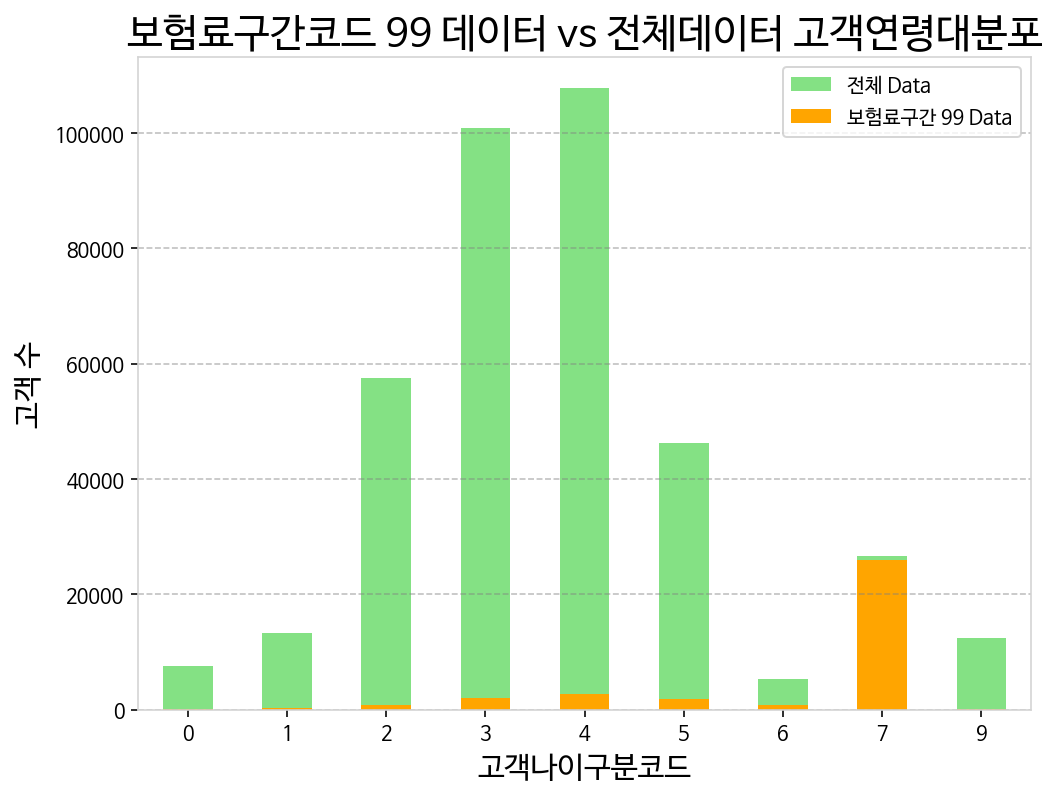

In [ ]:
ax=train_kor['고객나이구분코드'].value_counts().sort_index().plot.bar(color='limegreen',figsize=(8,6),alpha=0.6, label='전체 Data')
ax=data_99['고객나이구분코드'].value_counts().sort_index().plot.bar(color='orange',figsize=(8,6), label='보험료구간 99 Data')
ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
plt.xlabel('고객나이구분코드', fontsize=15); plt.ylabel('고객 수', fontsize=15)
plt.xticks(rotation=0)
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.legend(loc='best')
plt.title('보험료구간코드 99 데이터 vs 전체데이터 고객연령대분포', fontsize=20)
plt.show()

### 질병데이터

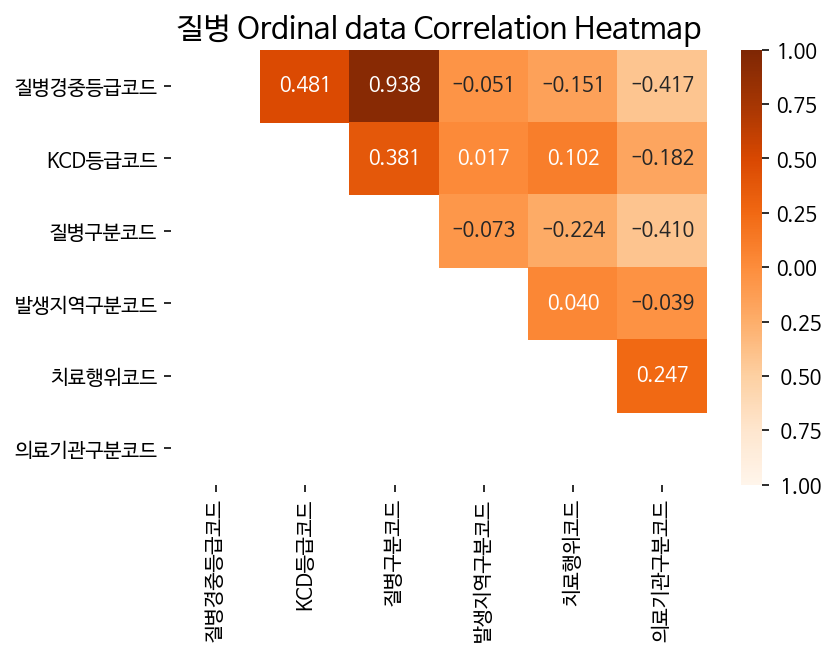

In [ ]:
corr_mat=train_kor[disease_order].corr()
mask=np.zeros_like(corr_mat,dtype=np.bool)
mask[np.tril_indices_from(mask)]=True

sns.heatmap(corr_mat,annot=True,cmap='Oranges',mask=mask, vmax=1,vmin=-1,fmt='.3f')
plt.title('질병 Ordinal data Correlation Heatmap',fontsize=15)
plt.show()

### `의료기관구분코드`
>- 의료기관구분코드에서 실사상태코드(target)별 분포를 보면, 1(일반병원), 2(종합병원), 3(상급종합병원) 순으로 자동지급의 비율이 높습니다. 
- 3(상급종합병원)에서는 ‘자동지급’보다 ‘조사’의 비율이 높습니다. 9(Unknown)에서는 ‘자동지급’보다 ‘조사’의 비율이 매우 높은 것을 볼 수 있습니다.
- Train set에는 의료기관구분코드 9 (Unknown)이 있으나, Test set 에는 없습니다. Train set에서 Unknown 이 차지하는 비율은 약 0.051% 으로 매우 작습니다. 

In [ ]:
print('Train set 의료기관구분코드: \n',train_kor['의료기관구분코드'].value_counts().sort_index())
print('\n')
print('Test set 의료기관구분코드: \n',test_kor['의료기관구분코드'].value_counts().sort_index())

Train set 의료기관구분코드: 
 1    100934
2    207836
3     68965
9       193
Name: 의료기관구분코드, dtype: int64


Test set 의료기관구분코드: 
 1     6666
2    11721
3     3685
Name: 의료기관구분코드, dtype: int64


In [ ]:
# 전체 데이터에서 의료기관구분코드가 차지하는 비율 확인
의료9_percent = np.round(len(train_kor[train_kor['의료기관구분코드'] == 9])/len(train_kor)*100, 3)
print(f'의료기관구분코드 9에 해당하는 데이터의 비율: {의료9_percent}%')

의료기관구분코드 9에 해당하는 데이터의 비율: 0.051%


### `치료행위코드`
>- 치료행위코드 카테고리별 실사상태코드(target)의 분포를 보면, ‘질병 진단’이라는 설명이 있을 때 ‘조사’의 비율이 높습니다. 반면 ‘질병 진단’이 속하지 않고 ‘수술 치료 진행’이 속할 때 ‘자동지급’의 비율이 높습니다. 





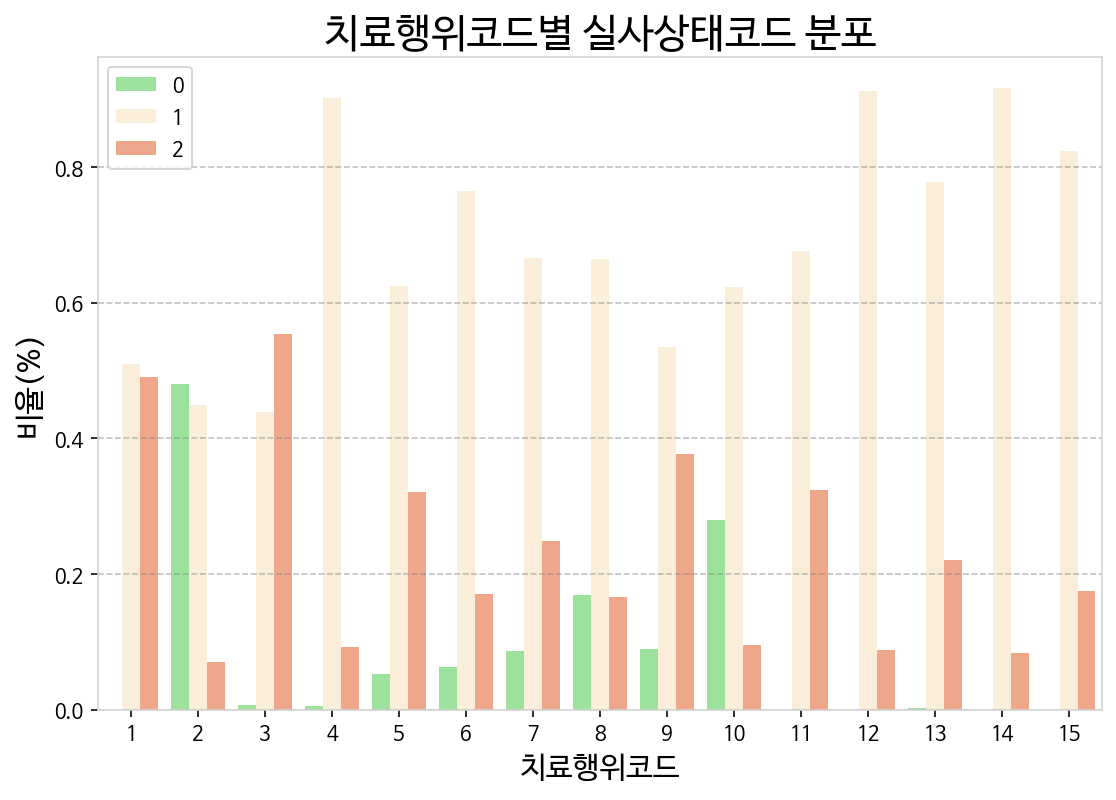

In [ ]:
plt.figure(figsize=(9,6))
bar_stack_target_ver_1(train_kor,'치료행위코드')

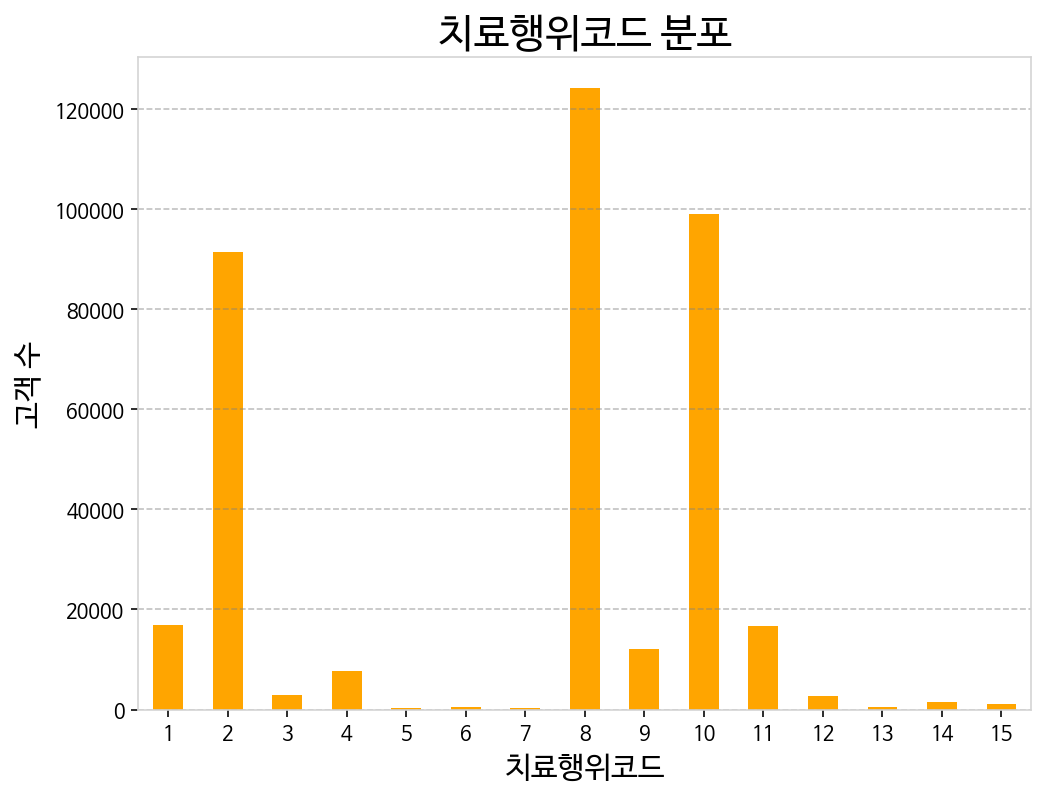

In [ ]:
ax = train_kor['치료행위코드'].value_counts().sort_index().plot.bar(color='orange',figsize=(8,6))
plt.title('치료행위코드 분포',fontsize=20);plt.xlabel('치료행위코드',fontsize=15);plt.ylabel('고객 수',fontsize=15); 
plt.xticks(rotation = 0)
ax.spines['top'].set_color('lightgrey'); ax.spines['right'].set_color('lightgrey'); ax.spines['bottom'].set_color('lightgrey'); ax.spines['left'].set_color('lightgrey');
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.show()

#3. 변수 선택

> Feature Enginnering



###1) 계절성
> *train* -> **201901~201911**<br/>
*test* -> **201912**
>>`계절` = 4계절로 변수 추가<br/>
>>`6분할` = 12개월을 2개월씩 카테고리 변수 추가<br/>
>>`2분할` = *test*에 속한 12월 포함 `target` 비율의 비슷한 추이로 2분할 변수 추가<br/>

In [5]:
train_kor['계절'] = 0
train_kor.loc[train_kor['접수년월'].isin([201902,201903,201904]),'계절'] = 1
train_kor.loc[train_kor['접수년월'].isin([201905,201906,201907]),'계절'] = 2
train_kor.loc[train_kor['접수년월'].isin([201908,201909,201910]),'계절'] = 3
train_kor.loc[train_kor['접수년월'].isin([201911,201901]),'계절'] = 4
train_kor['6분할'] = 0
train_kor.loc[train_kor['접수년월'].isin([201901,201902]),'6분할'] = 1
train_kor.loc[train_kor['접수년월'].isin([201903,201904]),'6분할'] = 2
train_kor.loc[train_kor['접수년월'].isin([201905,201906]),'6분할'] = 3
train_kor.loc[train_kor['접수년월'].isin([201907,201908]),'6분할'] = 4
train_kor.loc[train_kor['접수년월'].isin([201909,201910]),'6분할'] = 5
train_kor.loc[train_kor['접수년월'].isin([201911]),'6분할'] = 6
test_kor['계절'] = 4
test_kor['6분할'] = 6
train_kor['2분할'] = 0
train_kor.loc[train_kor['접수년월'].isin([201910,201911,201901,201902]),'2분할'] = 1
train_kor.loc[train_kor['접수년월'].isin([201903,201904,201905,201906,201907,201908,201909]),'2분할'] = 2
test_kor['2분할'] = 1

###2) 치료행위 여부
> 코드별 Y로 해당되는 치료행위 여부에 대한 변수 추가

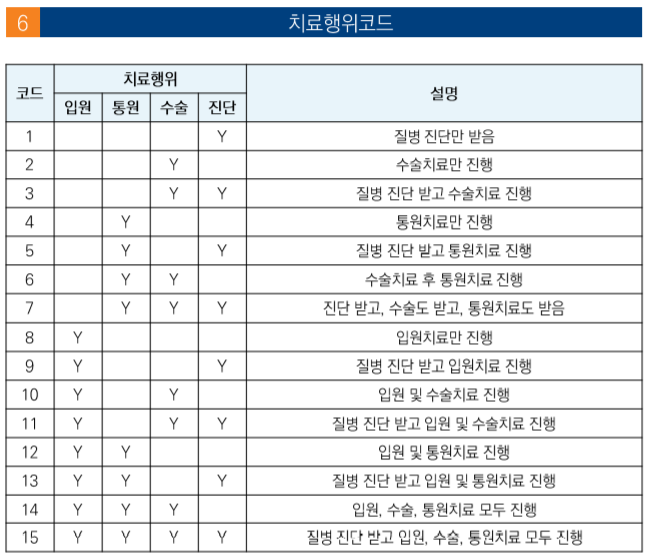

In [6]:
train_kor['통원여부'] = 0
train_kor.loc[train_kor['치료행위코드'].isin([4,5,6,7,12,13,14,15]),'통원여부'] = 1
train_kor['입원여부'] = 0
train_kor.loc[train_kor['치료행위코드'].isin([8,9,10,11,12,13,14,15]),'입원여부'] = 1
train_kor['수술여부'] = 0
train_kor.loc[train_kor['치료행위코드'].isin([2,3,6,7,10,11,14,15]),'수술여부'] = 1
test_kor['통원여부'] = 0
test_kor.loc[test_kor['치료행위코드'].isin([4,5,6,7,12,13,14,15]),'통원여부'] = 1
test_kor['입원여부'] = 0
test_kor.loc[test_kor['치료행위코드'].isin([8,9,10,11,12,13,14,15]),'입원여부'] = 1
test_kor['수술여부'] = 0
test_kor.loc[test_kor['치료행위코드'].isin([2,3,6,7,10,11,14,15]),'수술여부'] = 1

###3) 의료기관구분코드
> test data에 존재하지 않는 의료기관구분코드 9를 제거했습니다.

In [7]:
train_kor = train_kor[train_kor['의료기관구분코드']!=9]

#4. 모델 학습 및 검증

> Model Tuning & Evalution  




- 피쳐 스케일링 및 오버샘플링
 - 원핫인코딩, Normalization, Scaling, SMOTE 등 다양한 방법을 시도했으나 유의미한 결과를 얻지 못했습니다.

- 모델 선택
 - 사용 모델 : XGBoost / RandomForest / Catboost / LightGBM
 - 가장 점수가 잘 나오는 lightgbm으로 모델 결정
- 파라미터 튜닝 및 일반화
 - Bayesian Optimization으로 하이퍼 파라미터 튜닝  
 - lightgbm 학습시 5개의 seed를 사용하여 평균값 사용

- 재학습
 1. 학습 이후 각 row별로 예측된 class들의 최대확률이 0.84 이상인 데이터는 예측이 맞았다고 가정
 2. 0.84 미만인 데이터들을 다시 train data에 추가해서 재학습
 3. 위 과정 두 번 반복

In [8]:
df = train_kor.copy()
df_test = test_kor.copy()
df.drop(['접수일련번호','접수년월'],axis=1,inplace=True)
df_test.drop(['접수일련번호','접수년월'],axis=1,inplace=True)
features = df.drop(['실사상태코드'],axis=1)
target = df['실사상태코드']

In [9]:
parms = {
    'learning_rate' : 0.2,
    'num_leaves' : 700,
    'n_estimators' : 800,
    'max_depth': 600,
    'min_child_samples' : 5, 
    'min_child_weight' :0.01,
    'subsample' : 0.5,
    'colsample_bytree' : 1,
    'objective' : 'multiclass',
    'n_jobs': -1,
    'scale_pos_weight' : 1,
}

- validation set을 만들어서 대략적인 모델 성능 및 f1_score 확인

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's multi_logloss: 0.200936
[100]	valid_0's multi_logloss: 0.137104
[150]	valid_0's multi_logloss: 0.106023
[200]	valid_0's multi_logloss: 0.0887947
[250]	valid_0's multi_logloss: 0.0791514
[300]	valid_0's multi_logloss: 0.0728715
[350]	valid_0's multi_logloss: 0.0698906
[400]	valid_0's multi_logloss: 0.0687278
[450]	valid_0's multi_logloss: 0.0685452
Early stopping, best iteration is:
[439]	valid_0's multi_logloss: 0.0684782
f1_score: 0.9750342205517102


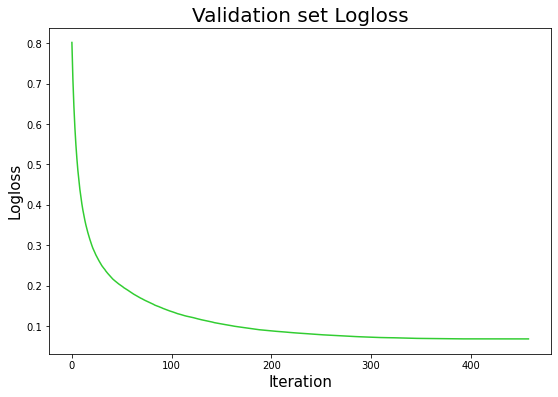

In [11]:
def model_1(features, target, df_test):
  X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=199)
  evals = [(X_val, y_val)]
  model = lightgbm.LGBMClassifier(**parms)
  model.fit(X_train, y_train, eval_set = evals, early_stopping_rounds=20, verbose = 50)

  pred = model.predict(X_val)
  f1 = f1_score(y_val,pred,average='macro')
  print('f1_score:', f1)

  fig, axes = plt.subplots(1, 1, figsize=(9, 6))
  axes.plot(model.evals_result_['valid_0']['multi_logloss'], color='limegreen', label='valid') 
  axes.set_title('Validation set Logloss', fontsize=20)
  axes.set_xlabel('Iteration', fontsize=15); axes.set_ylabel('Logloss', fontsize=15)
  return 

model_1(features, target, df_test)

- 최종모델 

In [10]:
for i in tqdm_notebook(range(1,6)):
    model = lightgbm.LGBMClassifier(**parms,random_state=i)
    model.fit(features,target)
    globals()['pred{}'.format(i)] = model.predict_proba(df_test)
pred = (pred1+pred2+pred3+pred4+pred5)/5
pred = pd.DataFrame(pred)
pred = pred.assign(largest=pred.max(axis=1), name=pred.idxmax(axis=1))

KeyboardInterrupt: ignored

In [ ]:
submission=pred['name'].copy()
for i in tqdm_notebook(range(0,2)):
    idx = pred[pred['largest']<=0.84].index
    not_idx = pred[pred['largest']>0.84].index
    test_kor['실사상태코드'] = pred['name']
    train_kor = train_kor.append(test_kor.loc[not_idx,:])
    test_kor = test_kor.loc[idx,:].drop('실사상태코드',axis=1)
    df = train_kor.copy()
    df_test = test_kor.copy()
    df.drop(['접수일련번호','접수년월'],axis=1,inplace=True)
    df_test.drop(['접수일련번호','접수년월'],axis=1,inplace=True)
    features = df.drop(['실사상태코드'],axis=1)
    target = df['실사상태코드'].astype('int64')

    model = lightgbm.LGBMClassifier(**parms)
    model.fit(features,target)
    pred = model.predict_proba(df_test)
    pred = pd.DataFrame(pred)
    pred = pred.assign(largest=pred.max(axis=1), name=pred.idxmax(axis=1))
    pred.index =  df_test.index
    submission[idx] = pred['name']

In [13]:
pip install eli5

     |████████████████████████████████| 112kB 6.1MB/s 


**Permutation importance**

In [16]:
import eli5 
from eli5.sklearn import PermutationImportance 
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=199)
model = lightgbm.LGBMClassifier(**parms)
evals = [(X_val, y_val)]
model.fit(X_train, y_train, eval_set = evals, early_stopping_rounds=20, verbose = 50)

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's multi_logloss: 0.200936
[100]	valid_0's multi_logloss: 0.137104
[150]	valid_0's multi_logloss: 0.106023
[200]	valid_0's multi_logloss: 0.0887947
[250]	valid_0's multi_logloss: 0.0791514
[300]	valid_0's multi_logloss: 0.0728715
[350]	valid_0's multi_logloss: 0.0698906
[400]	valid_0's multi_logloss: 0.0687278
[450]	valid_0's multi_logloss: 0.0685452
Early stopping, best iteration is:
[439]	valid_0's multi_logloss: 0.0684782


ValueError: ignored

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, average='macro')
perm = PermutationImportance(model, random_state=1,scoring=f1_scorer).fit(X_val,y_val)
eli5.show_weights(perm, feature_names = val_X.columns.tolist()) 

KeyboardInterrupt: ignored

In [ ]:
submission.to_csv('./submission.csv')

#5. 결과 및 결언



> Conclusion & Discussion



 + 2019년 12월 보험청구건분류 예측 결과

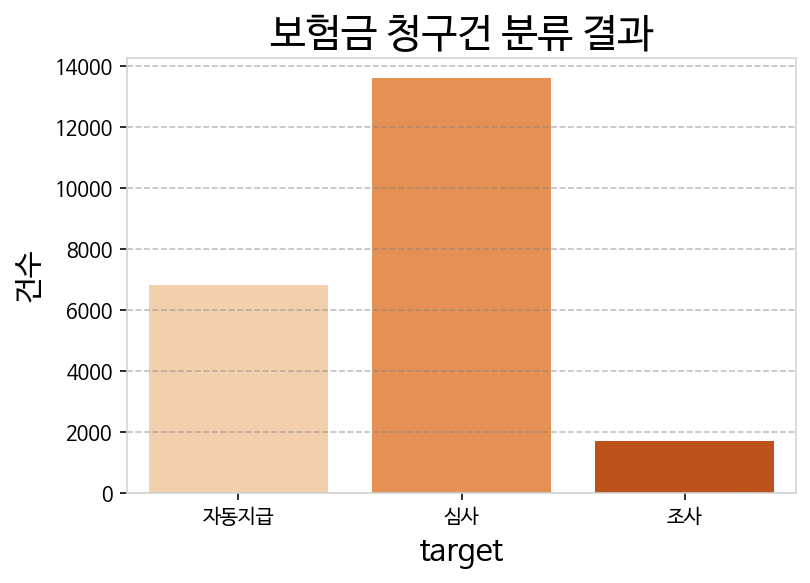

In [ ]:
result = pd.read_csv('/content/drive/My Drive/data/submission.csv')
result=result.rename(columns={'Unnamed: 0':'ID', 'name': 'target'})

target_count = result['target'].value_counts().reset_index().rename(columns = {'index':'target','target':'건수'})
target_plot(target_count, 'target', '건수')

In [ ]:
# 결과 확인
target_count['비율']=target_count['건수']/sum(target_count['건수'])
target_count

,target,건수,비율
0,1,13584,0.615440
1,0,6794,0.307811
2,2,1694,0.076749


In [ ]:
test_2['실사상태코드']=result['target']
test_2.head()

,접수일련번호,접수년월,질병경중등급코드,KCD등급코드,질병구분코드,발생지역구분코드,치료행위코드,의료기관구분코드,요양병원여부,통원횟수,청구보험금,입원일수,병원별평균입원청구보험금,병원별평균통원청구보험금,병원별평균수술청구보험금,병원별평균진단청구보험금,질병별평균입원청구보험금,질병별평균통원청구보험금,질병별평균수술청구보험금,질병별평균진단청구보험금,입원청구건수,수술청구건수,통원청구건수,고객나이구분코드,보험사기이력고객여부,부담보5년경과여부,중도부가계약여부,건강인우대계약여부,보험료구간코드,가입금액구간코드,청구일계약일간기간구분코드,청구일부활일간기간구분코드,부실판매자계약여부,접수월,실사상태코드
0,0,201912,3,4,28,1,2,1,1,0.0,0.4242,0.0000,0.0000,0.0000,0.2938,0.0000,0.1309,0.0000,0.1397,0.0000,0.0000,1.0548,0.0,2,0,0,0,0,1,9,5,0,0,12,0
1,1,201912,1,9,5,1,2,3,0,0.0,1.7688,0.0000,0.7517,1.5266,2.1745,1.3936,0.5344,0.5200,1.0923,1.1121,0.0000,1.0000,0.0,2,0,0,0,0,1,6,6,0,0,12,1
2,2,201912,1,3,1,1,1,3,0,0.0,43.0108,0.0000,1.2090,1.6061,1.6884,1.0524,1.1660,1.1593,1.2975,1.1091,0.0000,0.0000,0.0,2,0,0,0,0,1,3,6,0,0,12,1
3,3,201912,1,3,1,3,10,2,0,0.0,4.1867,0.1847,0.2785,0.1228,0.8927,0.3889,1.1660,1.1593,1.2975,1.1091,0.6667,1.2660,0.0,4,0,0,0,0,1,4,6,0,0,12,1
4,4,201912,3,14,27,1,2,1,1,0.0,0.4431,0.0000,0.0000,0.0000,0.2440,0.0000,0.1309,0.0000,0.1397,0.0000,0.0000,1.0000,0.0,2,0,0,0,0,1,2,6,0,0,12,0


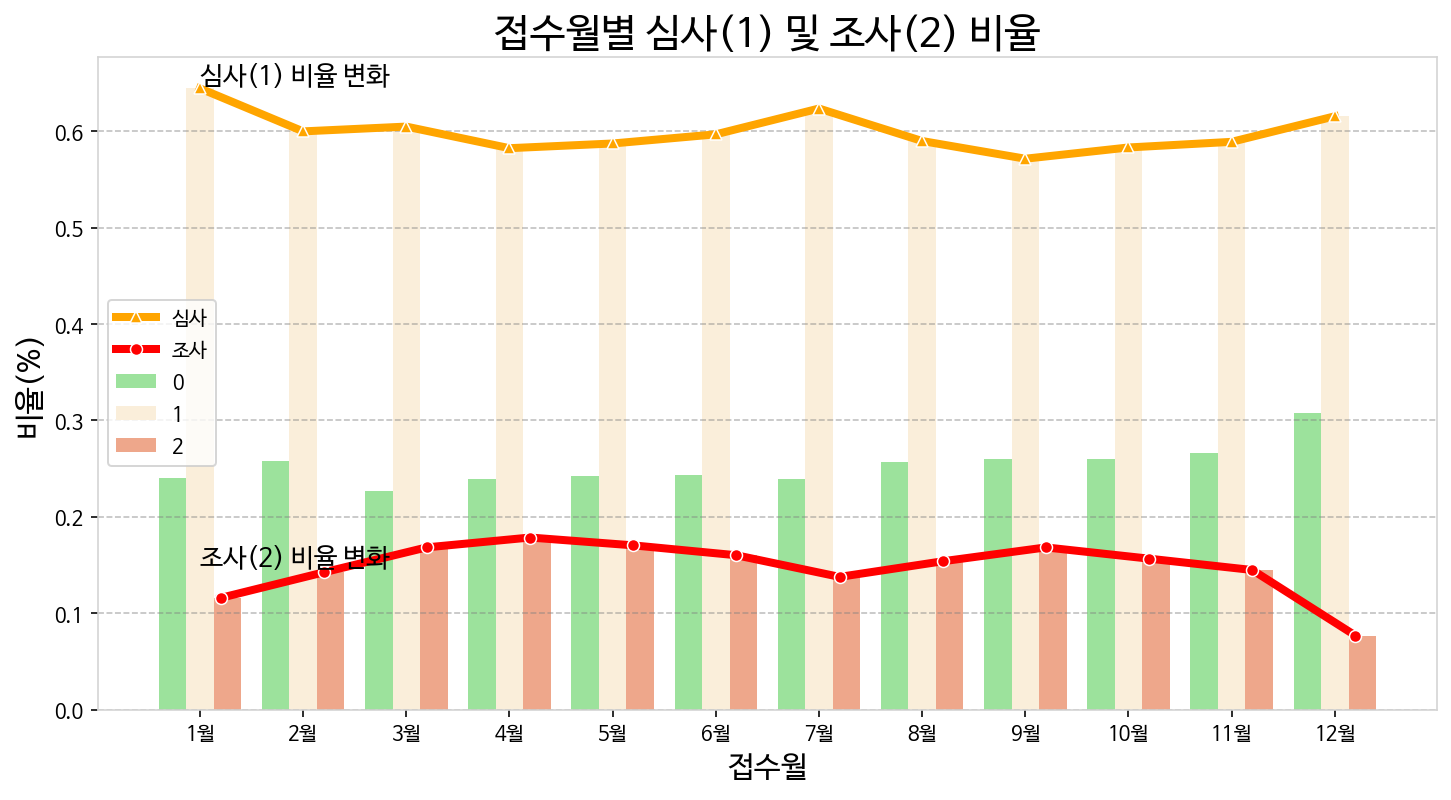

In [ ]:
new_data = pd.concat([train_2,test_2], axis = 0)
plt.figure(figsize=(12,6))
bar_stack_target_month(new_data,'접수월')

###최종 공개 리더보드 점수 : **87.0744**